# MIRI LRS Optimal Spectral Extraction

**Use case:** Extract spectra with different locations, extraction apertures, and techniques.<br>
**Data:** Simulated MIRI LRS spectrum.<br>
**Tools:** specreduce, jdaviz, jwst, gwcs, astropy.<br>
**Cross-intrument:** NIRSpec, MIRI.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

## Introduction

This notebook extracts a 1D spectra from a 2D MIRI LRS spectral observation (single image).  The goal is to provide the ability to extract spectra with different locations, extraction apertures, and techniques than are done in the JWST pipeline.

The simpliest spectral extraction is "boxcar" where all the pixels within some fixed width centered on the source position are summed at each wavelength.  Background subtraction can be done using regions offset from the source center.

For spectra taken with a diffraction limited telescope like JWST, a modification boxcar extraction is to vary the extraction width linearly with wavelength.  Such a scaled boxcar extraction keeps the fraction of the source flux within the extraction region approximately constant with wavelength.

For point sources, a PSF-weighted spectral extraction can be done.  Using the PSF to weight the extraction uses the actual PSF as a function of wavelength to optimize the extraction to the pixels with the greatest signal.  PSF-weighted extractions show the largest differences with boxcar extractions at lower S/N values.

**Note:** Corrections for the finite aperture used in all the extractions have not been applied.  Thus, the physical flux densities of all the extracted spectra are lower than the actual values.

## Imports

- *matplotlib.pyplot* for plotting data
- *numpy* to handle array functions
- *astropy.specreduce* for optimal extraction
- *astropy.io fits* for accessing FITS files
- *astropy.visualization* for scaling image for display
- *astropy.table Table* for reading the pipeline 1d extractions
- *jwst datamodels* for reading/access the jwst data

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import simple_norm

from jwst import datamodels

In [3]:
# useful function that work for boxcar, boxcar scaled with wavelength,
# and psf-weighted extractions
import numpy as np
from gwcs.wcstools import grid_from_bounding_box


def get_boxcar_weights(center, hwidth, npix):
    """
    Compute the weights given an aperture center, half widths, and number of pixels
    """
    weights = np.zeros((npix))
    # pixels with full weight
    fullpixels = [max(0, int(center - hwidth + 1)), min(int(center + hwidth), npix)]
    weights[fullpixels[0] : fullpixels[1]] = 1.0

    # pixels at the edges of the boxcar with partial weight
    if fullpixels[0] > 0:
        weights[fullpixels[0] - 1] = hwidth - (center - fullpixels[0])
    if fullpixels[1] < npix:
        weights[fullpixels[1]] = hwidth - (fullpixels[1] - center)

    return weights


def ap_weight_images(
    center, width, bkg_offset, bkg_width, image_size, waves, wavescale=None
):
    """
    Create a weight image that defines the desired extraction aperture
    and the weight image for the requested background regions

    Parameters
    ----------
    center : float
        center of aperture in pixels
    width : float
        width of apeture in pixels
    bkg_offset : float
        offset from the extaction edge for the background
        never scaled for wavelength
    bkg_width : float
        width of background region
        never scaled with wavelength
    image_size : tuple with 2 elements
        size of image
    waves : array
        wavelegth values
    wavescale : float
        scale the width with wavelength (default=None)
        wavescale gives the reference wavelenth for the width value

    Returns
    -------
    wimage, bkg_wimage : (2D image, 2D image)
        wimage is the weight image defining the aperature
        bkg_image is the weight image defining the background regions
    """
    wimage = np.zeros(image_size)
    bkg_wimage = np.zeros(image_size)
    hwidth = 0.5 * width
    # loop in dispersion direction and compute weights
    for i in range(image_size[1]):
        if wavescale is not None:
            hwidth = 0.5 * width * (waves[i] / wavescale)

        wimage[:, i] = get_boxcar_weights(center, hwidth, image_size[0])

        # bkg regions
        if (bkg_width is not None) & (bkg_offset is not None):
            bkg_wimage[:, i] = get_boxcar_weights(
                center - hwidth - bkg_offset, bkg_width, image_size[0]
            )
            bkg_wimage[:, i] += get_boxcar_weights(
                center + hwidth + bkg_offset, bkg_width, image_size[0]
            )
        else:
            bkg_wimage = None

    return (wimage, bkg_wimage)


def extract_1dspec(jdatamodel, center, width, bkg_offset, bkg_width, wavescale=None):
    """
    Extract the 1D spectrum using the boxcar method.
    Does a background subtraction as part of the extraction.

    Parameters
    ----------
    jdatamodel : jwst.DataModel
        jwst datamodel with the 2d spectral image
    center : float
        center of aperture in pixels
    width : float
        width of apeture in pixels
    bkg_offset : float
        offset from the extaction edge for the background
        never scaled for wavelength
    bkg_width : float
        width of background region
        never scaled with wavelength
    wavescale : float
        scale the width with wavelength (default=None)
        wavescale gives the reference wavelenth for the width value

    Returns
    -------
    waves, ext1d : (ndarray, ndarray)
        2D `float` array with wavelengths
        1D `float` array with extracted 1d spectrum in Jy
    """
    # should be determined from the gWCS in cal.fits
    image = np.transpose(jdatamodel.data)
    grid = grid_from_bounding_box(jdatamodel.meta.wcs.bounding_box)
    ra, dec, lam = jdatamodel.meta.wcs(*grid)
    lam_image = np.transpose(lam)

    # compute a "rough" wavelength scale to allow for aperture to scale with wavelength
    rough_waves = np.average(lam_image, axis=0)

    # images to use for extraction
    wimage, bkg_wimage = ap_weight_images(
        center,
        width,
        bkg_width,
        bkg_offset,
        image.shape,
        rough_waves,
        wavescale=wavescale,
    )

    # extract the spectrum using the weight image
    if bkg_wimage is not None:
        ext1d_boxcar_bkg = np.average(image, weights=bkg_wimage, axis=0)
        data_bkgsub = image - np.tile(ext1d_boxcar_bkg, (image.shape[0], 1))
    else:
        data_bkgsub = image

    ext1d = np.sum(data_bkgsub * wimage, axis=0)
    # convert from MJy/sr to Jy
    ext1d *= 1e6 * jdatamodel.meta.photometry.pixelarea_steradians

    # compute the average wavelength for each column using the weight image
    # this should correspond directly with the extracted spectrum
    #   wavelengths account for any tiled spectra this way
    waves = np.average(lam_image, weights=wimage, axis=0)

    return (waves, ext1d, data_bkgsub)

### Devloper notes

The difference between the pipeline (x1d) and the extractions done in this notebook are quite large.  Help in understanding the origin of these differences is needed.

Not clear how to use the JWST pipeline `extract_1d` (quite complex) code.
Help to determine how to use the JWST pipeline code instead of the custom code for boxcar is needed. 

Applying aperture corrections for the finite extraction widths is needed.  Help in how to get the needed informatinom for different (user set) extraction widths is needed. 

## Download Files

In [4]:
from astropy.utils.data import download_file

calfilename = "det_image_seq5_MIRIMAGE_P750Lexp1_cal.fits"
s2dfilename = "det_image_seq5_MIRIMAGE_P750Lexp1_s2d.fits"
x1dfilename = "det_image_seq5_MIRIMAGE_P750Lexp1_x1d.fits"
spatialprofilefilename = "det_image_seq1_MIRIMAGE_P750Lexp1_s2d.fits"
mainurl = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_LRS_notebook/"

calfile_dld = download_file(mainurl + calfilename)
s2dfile_dld = download_file(mainurl + s2dfilename)
x1dfile_dld = download_file(mainurl + x1dfilename)
spatialprofilefile_dld = download_file(mainurl + spatialprofilefilename)

In [5]:
# rename files so that they have the right extensions
# required for the jwst datamodels to work
import os
calfile = calfile_dld + '_cal.fits'
os.rename(calfile_dld, calfile)
s2dfile = s2dfile_dld + '_s2d.fits'
os.rename(s2dfile_dld, s2dfile)
x1dfile = x1dfile_dld + '_x1d.fits'
os.rename(x1dfile_dld, x1dfile)
spatialprofilefile = spatialprofilefile_dld + '_s2d.fits'
os.rename(spatialprofilefile_dld, spatialprofilefile)

## File information

The data used is a simulation of a LRS slit observation for a blackbody with a similar flux density to the star BD+60d1753, a flux calibration star.  This simulation was created with MIRISim.
The simulated exposure was reduced using the JWST pipeline (v0.16.1) through the Detector1 and Spec2 stages.

The cal file is one of the Spec2 products and is the calibration full frame image. It contains:

1. (Primary): This HDU contains meta-data related to the observation and data reduction.
2. (SCI): The calibrated image. Units are MJy/sr.
3. (ERR): Uncertainty image.  Units are MJy/sr.
4. (DQ): Data quality image.
5. (VAR_POISSON): Unc. component 1: Poisson uncertainty image.  Units are (MJy/sr)^2.
6. (VAR_RNOISE): Unc. component 2: Read Noise uncertainty image.  Units are (MJy/sr)^2.
7. (VAR_FLAT): Unc. component 3: Flat Field uncertainty image.  Units are (MJy/sr)^2.
8. (ASDF_METADATA): Metadata.

The s2d file is one of the Spec2 products and containes the calibrated rectified cutout of the LRS Slit region.  It has:

1. (Primary): This HDU contains meta-data related to the observation and data reduction.
2. (WGT): Weight.
3. (CON): ??
4. (ASDF_METADATA): Metadata.

## Loading data

In [6]:
# use a jwst datamodel to provide a good interface to the data and wcs info
cal = datamodels.open(calfile)
s2d = datamodels.open(s2dfile)

Basic information about the image.

In [7]:
print("cal image")
print(cal.data.shape)
print(np.mean(cal.data))
print(np.amin(cal.data), np.amax(cal.data))
print("s2d image")
print(s2d.data.shape)
print(np.mean(s2d.data))
print(np.amin(s2d.data), np.amax(s2d.data))

cal image
(1024, 1032)
9.826068
-1199.9769 64995.82
s2d image
(387, 44)
603.8127
-942.0139 63358.58


Display the full 2D image

Text(0.5, 1.0, 'The full image from the MIRI IMAGER detector')

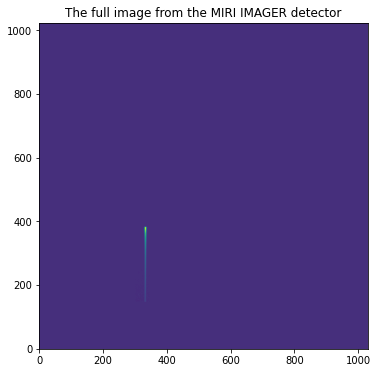

In [8]:
norm_data = simple_norm(cal.data, 'sqrt')
plt.figure(figsize=(6, 6))
plt.imshow(cal.data, norm=norm_data, origin="lower")
plt.title("The full image from the MIRI IMAGER detector")

Display the LRS Slit region only (use s2d)

Text(0.5, 1.0, 'The LRS region')

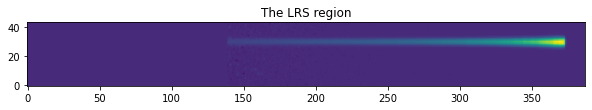

In [9]:
# transpose to make it display better
data_lrs_reg = np.transpose(s2d.data)
norm_data = simple_norm(data_lrs_reg, "sqrt")
plt.figure(figsize=(10, 3))
plt.imshow(data_lrs_reg, norm=norm_data, origin="lower")
plt.title("The LRS region")

JWST pipeline 1D extraction

<TableColumns names=('WAVELENGTH','FLUX','ERROR','SURF_BRIGHT','SB_ERROR','DQ','BACKGROUND','BERROR','NPIXELS')>


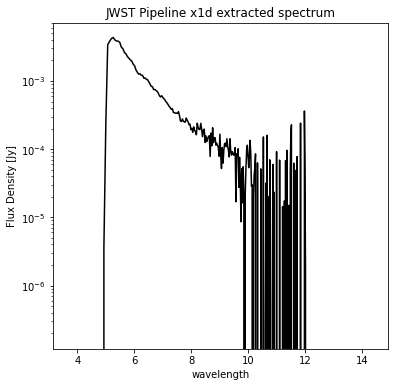

In [10]:
# for reference read in the JWST pipeline extracted spectrum
jpipe_x1d = Table.read(x1dfile, hdu=1)
print(jpipe_x1d.columns)
# plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(jpipe_x1d['WAVELENGTH'], jpipe_x1d['FLUX'], 'k-', label="jpipe_x1d")
ax.set_title("JWST Pipeline x1d extracted spectrum")
ax.set_xlabel("wavelength")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")

## Boxcar Extraction

Extract a 1D spectrum using a simple boxcar.  Basically collapse the spectrum in the cross-dispersion direction over a specified number of pixels.

Limitation: currently it is assumed there are no bad pixels.

### Fixed width boxcar

Define extraction parameters

In [11]:
ext_center = 30
ext_width = 8
bkg_offset = 4
bkg_width = 2

Plot cross-disperion cut showing the extraction parameters

Text(0.5, 1.0, 'Cross-dispersion Cut at Pixel=300')

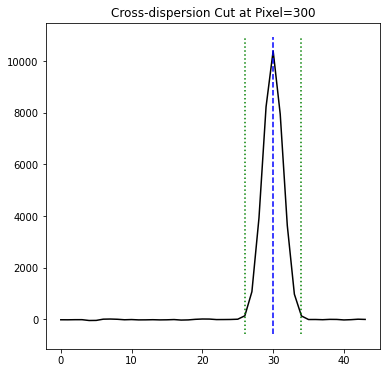

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
y = np.arange(data_lrs_reg.shape[0])
ax.plot(y, data_lrs_reg[:,300], 'k-')
mm = np.array([ext_center, ext_center])
mm_y = ax.get_ylim()
ax.plot(mm, mm_y, 'b--')
ax.plot(mm - ext_width/2., mm_y, 'g:')
ax.plot(mm + ext_width/2., mm_y, 'g:')
ax.set_title("Cross-dispersion Cut at Pixel=300")

Do the extraction

Text(0.5, 1.0, 'Fixed boxcar backgound weight image')

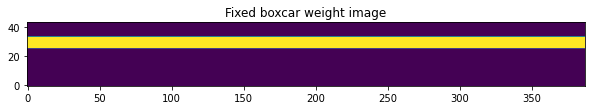

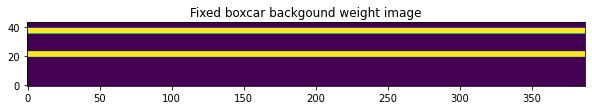

In [13]:
# visualize the weight images used in the fixed boxcar extraction 
wimage_fixedboxcar, wimage_fb_bkg = ap_weight_images(ext_center, ext_width, bkg_offset, 
                                                     bkg_width, data_lrs_reg.shape, None)

norm_data = simple_norm(wimage_fixedboxcar)
plt.figure(figsize=(10, 3))
plt.imshow(wimage_fixedboxcar, norm=norm_data, origin="lower")
plt.title("Fixed boxcar weight image")

norm_data = simple_norm(wimage_fb_bkg)
plt.figure(figsize=(10, 3))
plt.imshow(wimage_fb_bkg, norm=norm_data, origin="lower")
plt.title("Fixed boxcar backgound weight image")

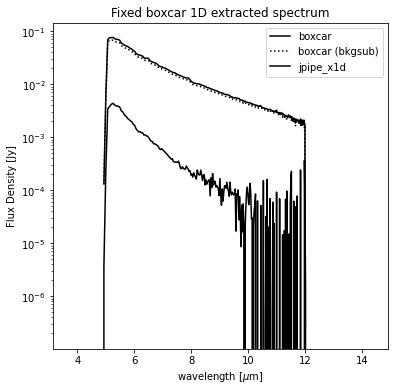

In [14]:
# extract the spectrum using the weight images

# without background subtraction
waves_boxcar, ext1d_boxcar, tmpval = extract_1dspec(s2d, ext_center, ext_width, None, None)

# with background subtraction
waves_boxcar_bkgsub, ext1d_boxcar_bkgsub, tmpval = extract_1dspec(s2d, ext_center, ext_width, 
                                                                  bkg_offset, bkg_width)

# plot
fig, ax = plt.subplots(figsize=(6, 6))
gpts = ext1d_boxcar_bkgsub > 0.
ax.plot(waves_boxcar[gpts], ext1d_boxcar[gpts], 'k-', label="boxcar")
ax.plot(waves_boxcar_bkgsub[gpts], ext1d_boxcar_bkgsub[gpts], 'k:', label="boxcar (bkgsub)")
ax.plot(jpipe_x1d['WAVELENGTH'], jpipe_x1d['FLUX'], 'k-', label="jpipe_x1d")
ax.set_title("Fixed boxcar 1D extracted spectrum")
ax.set_xlabel(r"wavelength [$\mu$m]")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")
ax.legend()

### Wavelength scaled width boxcar

The LRS spatial profile changes as a function of wavelength as JWST is diffraction limited at these wavelengths.  Nominally this means that the FWHM is changing linearly with wavelength.  Scaling the width of the extraction aperture with wavelength accounts for the changing diffraction limit with wavelength to first order.

Text(0.5, 1.0, 'Scaled boxcar backgound weight image')

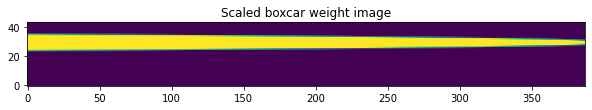

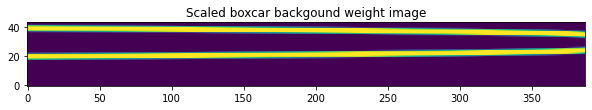

In [15]:
# visualize the weight images used in the scaled boxcar extraction 
wimage_scaledboxcar, wimage_sb_bkg = ap_weight_images(ext_center, ext_width, bkg_offset, bkg_width, 
                                                      data_lrs_reg.shape, waves_boxcar, wavescale=10.0)

norm_data = simple_norm(wimage_scaledboxcar)
plt.figure(figsize=(10, 3))
plt.imshow(wimage_scaledboxcar, norm=norm_data, origin="lower")
plt.title("Scaled boxcar weight image")

norm_data = simple_norm(wimage_sb_bkg)
plt.figure(figsize=(10, 3))
plt.imshow(wimage_sb_bkg, norm=norm_data, origin="lower")
plt.title("Scaled boxcar backgound weight image")

In [ ]:
# extract the spectrum using the weight image

# with background subtraction
waves_sboxcar_bkgsub, ext1d_sboxcar_bkgsub, sboxcar_bkgsub_image = extract_1dspec(s2d, ext_center, 
                                                                                  ext_width, bkg_offset, 
                                                                                  bkg_width, wavescale=10)

# plot
fig, ax = plt.subplots(figsize=(6, 6))
gpts = ext1d_boxcar_bkgsub > 0.
ax.plot(waves_boxcar_bkgsub[gpts], ext1d_boxcar_bkgsub[gpts], 'k:', label="fixed boxcar (bkgsub)")
gpts = ext1d_sboxcar_bkgsub > 0.
ax.plot(waves_sboxcar_bkgsub[gpts], ext1d_sboxcar_bkgsub[gpts], 'k-', label="scaled boxcar (bkgsub)")
ax.set_title("Scaled boxcar 1D extracted spectrum")
ax.set_xlabel("wavelength [$\mu$m]")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1e-1)
ax.legend()

Note that the impact of the scaled boxcar is largest at shorter wavelengths.  This is the result of using the same aperature at 10 microns for both the boxcar and scaled boxcar.


## PSF based Extraction

While to first order the PSF FHWM changes linearly with wavelength, this is an approximation.  It is better to use the measured spatial profile as a function of wavelength to extract the spectrum.  This tracks the actual variation with wavelength and optimizes the extraction to the higher S/N measurements.  In general, PSF based extractions show the most improvements over boxcar extractions at lower the S/N.

There are two PSF based extraction methods.

1. PSF weighted: the spatial profile at each wavelength is used to weight the extraction.
2. PSF fitting: the spatial profile is fit at each wavelength with the scale parameter versus wavelength giving the spectrum.

Only the PSF weighted technique is currently part of this notebook.

Note 1: calibration reference file for the specific LRS slit position should be used.

Note 2: Small shifts in the centering of the source in the slit should be investigated to see if they impact the PSF based extractions.

Limitation: currently it is assumed there are no bad pixels.

### PSF weighted extaction

#### Generate the PSF profile as a function of wavelength
For MIRI LRS slit observations, observations are made at two nod position in the slit after target acquisition.  This means that the location of the sources in the slit is very well known.  Hence, spatial profile (PSF) as a function of wavelength for the two nod positions is straightforward to measure using observations of a bright source.

The next few steps generate the needed information for the nod position for which we are extracting spectra based on a simulation of a bright source at the same nod position.

In [ ]:
# lrs spatial profile (PSF) as a function of wavelength
# currently, this is just a "high" S/N observation of a flat spectrum source at the same slit position
psf = datamodels.open(spatialprofilefile)
# transpose to make it display better
lrspsf = np.transpose(psf.data)
norm_data = simple_norm(lrspsf, "sqrt")
plt.figure(figsize=(10, 3))
plt.imshow(lrspsf, norm=norm_data, origin="lower")
plt.title("The LRS Spatial Profile (PSF) Observation")

In [ ]:
# Mock a LRS spectral profile reference file
# Sum along the spatial direction and normalize to 1
# assume there is no background (none was included in the MIRISim for the flat spectrum source observation)
# ignore regions far from the source using a scaled boxcar weight image
#   the aperture (psf_width) used in the scaled boxcar weight image could be varied
psf_width = 12.0
(wimage_scaledboxcar, tmpvar) = ap_weight_images(ext_center, psf_width, bkg_offset, bkg_width, data_lrs_reg.shape, waves_boxcar, wavescale=10.0)

psf_weightimage = lrspsf*wimage_scaledboxcar

# generate a 2D image of the column sums for division
max_psf = np.max(psf_weightimage, axis=0)
div_image = np.tile(max_psf, (psf_weightimage.shape[0], 1))
div_image[div_image == 0.0] = 1.0  # avoid divide by zero issues

# normalize 
psf_weightimage /= div_image

# display
norm_data = simple_norm(psf_weightimage, "sqrt")
plt.figure(figsize=(10, 3))
plt.imshow(psf_weightimage, norm=norm_data, origin="lower")
plt.title("The LRS Spatial Profile Reference Image (Normalized)")

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
y = np.arange(psf_weightimage.shape[0])
ax.plot(y, psf_weightimage[:,150], label="pixel=150")
ax.plot(y, psf_weightimage[:,225], label="pixel=225")
ax.plot(y, psf_weightimage[:,300], label="pixel=300")
ax.plot(y, psf_weightimage[:,370], label="pixel=370")
ax.set_title("Cross-dispersion Cuts")
ax.set_xlim(ext_center-psf_width, ext_center+psf_width)
ax.legend()

Note that the spatial profile becomes narrower as the pixel values increases as this corresponds to the wavelength decreasing.

#### Extract spectrum using wavelength dependent PSF profiles

In [ ]:
# use the normalized PSF weight image to extract the specrum
# use the background subtracted image from the scaled boxcar extraction
ext1d_psfweight = np.sum(sboxcar_bkgsub_image * psf_weightimage, axis=0)
ext1d_psfweight *= 1e6 * s2d.meta.photometry.pixelarea_steradians

# plot
fig, ax = plt.subplots(figsize=(6, 6))
gpts = ext1d_psfweight > 0.
ax.plot(waves_boxcar_bkgsub[gpts], ext1d_psfweight[gpts], 'k-', label="psf weighted (bkgsub)")
gpts = ext1d_sboxcar_bkgsub > 0.
ax.plot(waves_sboxcar_bkgsub[gpts], ext1d_sboxcar_bkgsub[gpts], 'k:', label="scaled boxcar (bkgsub)")
ax.set_title("PSF weigthed extracted spectrum")
ax.set_xlabel("wavelength [$\mu$m]")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1e-1)
ax.legend()

Note that the psf weighted extraction has visabily higher S/N, especially at the longer wavelengths where the S/N is lowest overall.

#### Plotting in Rayleigh-Jeans units

For sources that have stellar continuum, it can be useful to plot MIR spectra in Rayleigh-Jeans units.  This just means removing the spectral shape expected for a blackbody with a peak at much shorter wavelengths than the MIR.  This is easily done by multiplying the spectrum by lambda^4 or nu^2.

An example of this is given below.

In [ ]:
# Rayleigh-Jeans plot
fig, ax = plt.subplots(figsize=(6, 6))
gpts = ext1d_psfweight > 0.
ax.plot(waves_boxcar_bkgsub[gpts], (waves_boxcar_bkgsub[gpts]**4)*ext1d_psfweight[gpts], 'k-', label="psf weighted (bkgsub)")
gpts = ext1d_sboxcar_bkgsub > 0.
ax.plot(waves_sboxcar_bkgsub[gpts], (waves_sboxcar_bkgsub[gpts]**4)*ext1d_sboxcar_bkgsub[gpts], 'k:', label="scaled boxcar (bkgsub)")
gpts = ext1d_boxcar_bkgsub > 0.
ax.plot(waves_boxcar_bkgsub[gpts], (waves_boxcar_bkgsub[gpts]**4)*ext1d_boxcar_bkgsub[gpts], 'k--', label="fixed boxcar (bkgsub)")
ax.set_title("Rayleigh-Jeans plot for all extractions")
ax.set_xlabel("wavelength [$\mu$m]")
ax.set_ylabel("Rayleigh-Jeans Flux Density [$\mu$m$^4$ Jy]")
ax.set_yscale("log")
ax.set_ylim(10, 100)
ax.legend()

## Additional Resources

- [MIRI LRS](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-observing-modes/miri-low-resolution-spectroscopy)
- [MIRISim](http://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim)
- [JWST pipeline](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline)
- PSF weighted extraction [Horne 1986, PASP, 98, 609](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract).

## About this notebook

**Author:** Karl Gordon, JWST
**Updated On:** 2020-07-07

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 